In [22]:
import pandas as pd
import numpy as np
from math import log,sqrt
import matplotlib.pyplot as plt
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
%matplotlib inline

In [5]:
from wordcloud import WordCloud

In [29]:
df=pd.DataFrame()
df=pd.read_csv('spam.csv',encoding='latin-1')

In [7]:
df.head()

,text,spam
0,Subject: naturally irresistible your corporate...,1
1,Subject: the stock trading gunslinger fanny i...,1
2,Subject: unbelievable new homes made easy im ...,1
3,Subject: 4 color printing special request add...,1
4,"Subject: do not have money , get software cds ...",1


In [30]:
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

In [31]:
df

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives around here though",NaN,NaN,NaN
...,...,...,...,...,...
5567,spam,"This is the 2nd time we have tried 2 contact u. U have won the å£750 Pound prize. 2 claim is easy, call 087187272008 NOW1! Only 10p per minute. BT-national-rate.",NaN,NaN,NaN
5568,ham,Will Ì_ b going to esplanade fr home?,NaN,NaN,NaN
5569,ham,"Pity, * was in mood for that. So...any other suggestions?",NaN,NaN,NaN
5570,ham,The guy did some bitching but I acted like i'd be interested in buying something else next week and he gave it to us for free,NaN,NaN,NaN


In [33]:
df.drop(['Unnamed: 2','Unnamed: 3','Unnamed: 4'],axis=1,inplace=True)

In [35]:
df.rename(columns = {'v1': 'labels', 'v2': 'message'}, inplace = True)

In [36]:
df['label'] = df['labels'].map({'ham': 0, 'spam': 1})

In [38]:
df.drop(['labels'], axis = 1, inplace = True)

In [39]:
X=df['message']
y=df['label']

In [40]:
from sklearn.model_selection import train_test_split

In [41]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=2)

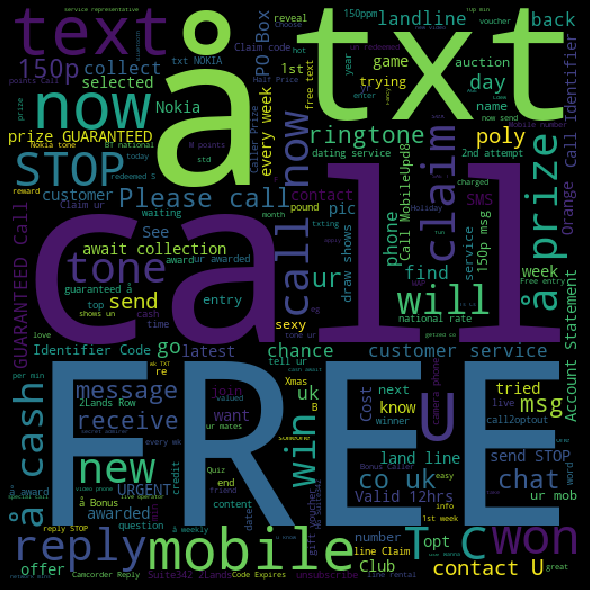

In [42]:
spam_words=''.join(list(df[df['label']==1]['message']))
spam_wc=WordCloud(width=512,height=512).generate(spam_words)
plt.figure(figsize=(10,8),facecolor='k')
plt.imshow(spam_wc)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

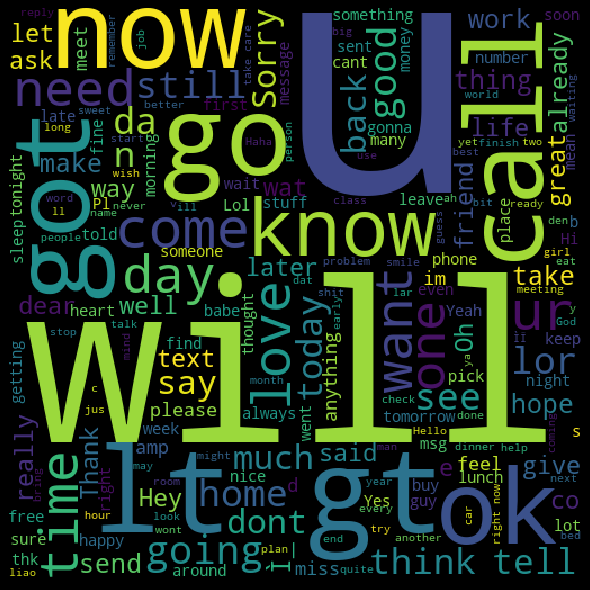

In [45]:
spam_words=''.join(list(df[df['label']==0]['message']))
spam_wc=WordCloud(width=512,height=512).generate(spam_words)
plt.figure(figsize=(10,8),facecolor='k')
plt.imshow(spam_wc)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [ ]:
def process_message(message, lower_case = True, stem = True, stop_words = True, gram = 2):
    if lower_case:
        message = message.lower()
    words = word_tokenize(message)
    words = [w for w in words if len(w) > 2]
    if gram > 1:
        w = []
        for i in range(len(words) - gram + 1):
            w += [' '.join(words[i:i + gram])]
        return w
    if stop_words:
        sw = stopwords.words('english')
        words = [word for word in words if word not in sw]
    if stem:
        stemmer = PorterStemmer()
        words = [stemmer.stem(word) for word in words]   
    return words

In [ ]:
class SpamClassifier(object):
    def __init__(self, trainData, method = 'tf-idf'):
        self.mails, self.labels = trainData['message'], trainData['label']
        self.method = method

    def train(self):
        self.calc_TF_and_IDF()
        if self.method == 'tf-idf':
            self.calc_TF_IDF()
        else:
            self.calc_prob()

    def calc_prob(self):
        self.prob_spam = dict()
        self.prob_ham = dict()
        for word in self.tf_spam:
            self.prob_spam[word] = (self.tf_spam[word] + 1) / (self.spam_words + \
                                                                len(list(self.tf_spam.keys())))
        for word in self.tf_ham:
            self.prob_ham[word] = (self.tf_ham[word] + 1) / (self.ham_words + \
                                                                len(list(self.tf_ham.keys())))
        self.prob_spam_mail, self.prob_ham_mail = self.spam_mails / self.total_mails, self.ham_mails / self.total_mails 


    def calc_TF_and_IDF(self):
        noOfMessages = self.mails.shape[0]
        self.spam_mails, self.ham_mails = self.labels.value_counts()[1], self.labels.value_counts()[0]
        self.total_mails = self.spam_mails + self.ham_mails
        self.spam_words = 0
        self.ham_words = 0
        self.tf_spam = dict()
        self.tf_ham = dict()
        self.idf_spam = dict()
        self.idf_ham = dict()
        for i in range(noOfMessages):
            message_processed = process_message(self.mails[i])
            count = list() #To keep track of whether the word has ocured in the message or not.
                           #For IDF
            for word in message_processed:
                if self.labels[i]:
                    self.tf_spam[word] = self.tf_spam.get(word, 0) + 1
                    self.spam_words += 1
                else:
                    self.tf_ham[word] = self.tf_ham.get(word, 0) + 1
                    self.ham_words += 1
                if word not in count:
                    count += [word]
            for word in count:
                if self.labels[i]:
                    self.idf_spam[word] = self.idf_spam.get(word, 0) + 1
                else:
                    self.idf_ham[word] = self.idf_ham.get(word, 0) + 1

    def calc_TF_IDF(self):
        self.prob_spam = dict()
        self.prob_ham = dict()
        self.sum_tf_idf_spam = 0
        self.sum_tf_idf_ham = 0
        for word in self.tf_spam:
            self.prob_spam[word] = (self.tf_spam[word]) * log((self.spam_mails + self.ham_mails) \
                                                          / (self.idf_spam[word] + self.idf_ham.get(word, 0)))
            self.sum_tf_idf_spam += self.prob_spam[word]
        for word in self.tf_spam:
            self.prob_spam[word] = (self.prob_spam[word] + 1) / (self.sum_tf_idf_spam + len(list(self.prob_spam.keys())))
            
        for word in self.tf_ham:
            self.prob_ham[word] = (self.tf_ham[word]) * log((self.spam_mails + self.ham_mails) \
                                                          / (self.idf_spam.get(word, 0) + self.idf_ham[word]))
            self.sum_tf_idf_ham += self.prob_ham[word]
        for word in self.tf_ham:
            self.prob_ham[word] = (self.prob_ham[word] + 1) / (self.sum_tf_idf_ham + len(list(self.prob_ham.keys())))
            
    
        self.prob_spam_mail, self.prob_ham_mail = self.spam_mails / self.total_mails, self.ham_mails / self.total_mails 
                    
    def classify(self, processed_message):
        pSpam, pHam = 0, 0
        for word in processed_message:                
            if word in self.prob_spam:
                pSpam += log(self.prob_spam[word])
            else:
                if self.method == 'tf-idf':
                    pSpam -= log(self.sum_tf_idf_spam + len(list(self.prob_spam.keys())))
                else:
                    pSpam -= log(self.spam_words + len(list(self.prob_spam.keys())))
            if word in self.prob_ham:
                pHam += log(self.prob_ham[word])
            else:
                if self.method == 'tf-idf':
                    pHam -= log(self.sum_tf_idf_ham + len(list(self.prob_ham.keys()))) 
                else:
                    pHam -= log(self.ham_words + len(list(self.prob_ham.keys())))
            pSpam += log(self.prob_spam_mail)
            pHam += log(self.prob_ham_mail)
        return pSpam >= pHam
    
    def predict(self, testData):
        result = dict()
        for (i, message) in enumerate(testData):
            processed_message = process_message(message)
            result[i] = int(self.classify(processed_message))
        return result

In [ ]:

def metrics(labels, predictions):
    true_pos, true_neg, false_pos, false_neg = 0, 0, 0, 0
    for i in range(len(labels)):
        true_pos += int(labels[i] == 1 and predictions[i] == 1)
        true_neg += int(labels[i] == 0 and predictions[i] == 0)
        false_pos += int(labels[i] == 0 and predictions[i] == 1)
        false_neg += int(labels[i] == 1 and predictions[i] == 0)
    precision = true_pos / (true_pos + false_pos)
    recall = true_pos / (true_pos + false_neg)
    Fscore = 2 * precision * recall / (precision + recall)
    accuracy = (true_pos + true_neg) / (true_pos + true_neg + false_pos + false_neg)

    print("Precision: ", precision)
    print("Recall: ", recall)
    print("F-score: ", Fscore)
    print("Accuracy: ", accuracy)

In [ ]:
sc_tf_idf = SpamClassifier(trainData, 'tf-idf')
sc_tf_idf.train()
preds_tf_idf = sc_tf_idf.predict(testData['message'])
metrics(testData['label'], preds_tf_idf)

In [ ]:

sc_bow = SpamClassifier(trainData, 'bow')
sc_bow.train()
preds_bow = sc_bow.predict(testData['message'])
metrics(testData['label'], preds_bow)

In [ ]:

pm = process_message('I cant pick the phone right now. Pls send a message')
sc_tf_idf.classify(pm)

In [ ]:

pm = process_message('Congratulations ur awarded $500 ')
sc_tf_idf.classify(pm)